In [1]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
from inference import fit_multiplicative,fit_multiplicative_ridge

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# generate coupling matrix w0: wji from j to i
def generate_interactions(n,m,g,sp,i1i2):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))

    # sparse
    for i in range(n):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        for j in range(n):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            if (np.abs(j-i) > 1) and (np.random.rand() < sp): 
                w[i1:i2,j1:j2] = 0.
    
    # sum_j wji to each position i = 0                
    for i in range(n):        
        i1,i2 = i1i2[i,0],i1i2[i,1]             
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            

    # no self-interactions
    for i in range(n):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        w[i1:i2,i1:i2] = 0.   # no self-interactions

    # symmetry
    for i in range(nm):
        for j in range(nm):
            if j > i: w[i,j] = w[j,i]       
        
    return w

In [4]:
# 2018.10.27: generate time series by MCMC
def generate_sequences(w,h0,n,m,l,i1i2):     
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()

    nrepeat = 5*n
    for irepeat in range(nrepeat):
        for i in range(n):
            i1,i2 = i1i2[i,0],i1i2[i,1]

            h = h0[np.newaxis,i1:i2] + s.dot(w[:,i1:i2])  # h[t,i1:i2]

            k0 = np.argmax(s[:,i1:i2],axis=1)
            for t in range(l):
                k = np.random.randint(0,m)                
                while k == k0[t]:
                    k = np.random.randint(0,m)
                
                if np.exp(h[t,k] - h[t,k0[t]]) > np.random.rand():
                    s[t,i1:i2],s[t,i1+k] = 0.,1.

        if irepeat%n == 0: print('irepeat:',irepeat) 

    return s

In [5]:
n = 40; m = 5; g = 4. ; sp = 0.7

#mx = np.array([len(np.unique(s0[:,i])) for i in range(n)])
mx = np.array([m for i in range(n)])
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

#w0 = generate_interactions(n,m,g,sp,i1i2)

In [6]:
#np.savetxt('w0_n40m5g4sp07.txt',w0,fmt='%f')

w0 = np.loadtxt('w0_n40m5g4sp07.txt')

In [7]:
#l = ((n*m)**2)
#l = 50000
h0 = np.zeros(n*m)
#s = generate_sequences(w0,h0,n,m,l,i1i2)

In [8]:
#s0 = np.array([s[:,i1i2[i,0]:i1i2[i,1]].argmax(axis=1) for i in range(n)]).T
#print(s0.shape)
#np.savetxt('s0_n40m5g4sp07.txt',s0,fmt='%i')

s0 = np.loadtxt('s0_n40m5g4sp07.txt')
print(s0.shape)

(50000, 40)


In [9]:
#l = s0.shape[0]
l = 1000
s0 = s0[:l]

In [10]:
nloop = 15
onehot_encoder = OneHotEncoder(sparse=False)
s = onehot_encoder.fit_transform(s0)

/home/tai/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
mx_sum = mx.sum()
my_sum = mx.sum() #!!!! my_sum = mx_sum

w = np.zeros((mx_sum,my_sum))
h0 = np.zeros(my_sum)
cost = np.zeros((n,nloop))
niter = np.zeros(n)

for i0 in range(n):
    print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]
    
    w1,h01,cost1,niter1 = fit_multiplicative_ridge(x,y,nloop,lamda=0.02)

    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

    h0[i1:i2] = h01
    cost[i0,:] = cost1
    niter[i0] = niter1

('i0:', 0)
('i0:', 1)
('i0:', 2)
('i0:', 3)
('i0:', 4)
('i0:', 5)
('i0:', 6)
('i0:', 7)
('i0:', 8)
('i0:', 9)
('i0:', 10)
('i0:', 11)
('i0:', 12)
('i0:', 13)
('i0:', 14)
('i0:', 15)
('i0:', 16)
('i0:', 17)
('i0:', 18)
('i0:', 19)
('i0:', 20)
('i0:', 21)
('i0:', 22)
('i0:', 23)
('i0:', 24)
('i0:', 25)
('i0:', 26)
('i0:', 27)
('i0:', 28)
('i0:', 29)
('i0:', 30)
('i0:', 31)
('i0:', 32)
('i0:', 33)
('i0:', 34)
('i0:', 35)
('i0:', 36)
('i0:', 37)
('i0:', 38)
('i0:', 39)


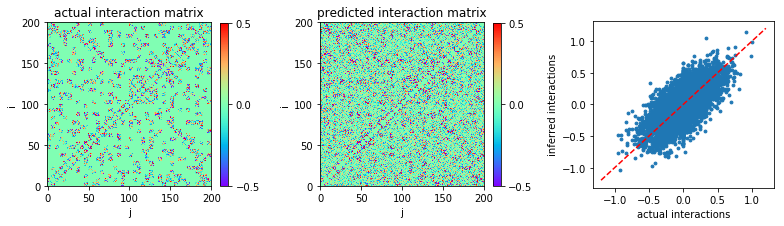

In [12]:
#np.savetxt('w_n40m5g4sp07.txt',w,fmt='%f')

plt.figure(figsize=(11,3.2))

plt.subplot2grid((1,3),(0,0))
plt.title('actual interaction matrix')
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.xticks(np.arange(0, 201, 50))
plt.yticks(np.arange(0, 201, 50))
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])

plt.subplot2grid((1,3),(0,1))
plt.title('predicted interaction matrix')
plt.imshow(w,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.xticks(np.arange(0, 201, 50))
plt.yticks(np.arange(0, 201, 50))
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])

plt.subplot2grid((1,3),(0,2))
plt.plot([-1.2,1.2],[-1.2,1.2],'r--')
plt.scatter(np.triu(w0),np.triu(w),s=8)
plt.xlabel('actual interactions')
plt.ylabel('inferred interactions')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.savefig('w_02_ridge.pdf', format='pdf', dpi=100)

In [13]:
#np.savetxt('w_02.txt',w,fmt='%f')